# Training to identify crossing points - Part II
Author: Jose Miguel Serra Lleti

This notebook corresponds to the article: __CLEMSite, a software for automated phenotypic screens using light microscopy and FIB-SEM.__

_Please, cite the original paper if using or developing this notebook._

In the previous notebook a convolutional neural network was trained to identify edges belonging to marks in the surface of sample (from a MatTek grid pattern) in SEM images. In this second part, we will use the network to convert the edges to lines and extract the center, which will be used as reference.

Then, we will use some of the images manually curated to find out the means square error (MSE) of our algorithm.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2                    
from PIL import Image
import time 
from shutil import copyfile
from tqdm import tqdm
import glob
import os
from keras import backend as K
from imp import reload
import os
import numpy as np
import cv2
from keras.preprocessing import image                  
from skimage import data, io, filters
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split
from skimage.morphology import square
from skimage.filters.rank import mean_bilateral
from skimage.morphology import erosion, dilation

def set_keras_backend(backend):

    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend
set_keras_backend('tensorflow')

Using TensorFlow backend.


In [2]:
### PREPROCESSING function and conversion to tensors, same as in part I
import numpy as np
import cv2

iclahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(32, 32))
# All images are preprocessed for unbalanced brightness and contrast and resized to 256 by 256
def preprocess(image):   
    image = cv2.GaussianBlur(image,(5,5),0)  
    n_image = iclahe.apply(np.uint8(image))
    final = np.array(n_image,dtype=np.float32)
    final = (final-np.min(final))/(np.max(final)-np.min(final)) # Normalization has to be done AFTER AUGMENTATION
    return final

def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    final = cv2.resize(img,(256,256))
    final = preprocess(final)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 1) and return 4D tensor    
    return np.expand_dims(final, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In the folder TEST, we have three scans. We will use them as example. First, load the images and predict them with the model to get the probability map of edges.

In [3]:
# Load TEST images
sample_test = [] 
# Load data
dirSample = ".\\data\\crosses"
flist = glob.glob(dirSample + "\\TEST\\SCAN*")
flistdir= [f for f in flist if os.path.isdir(f)]
if flistdir is None:
        raise Exception('--scanfolder not found')

for sample in flistdir:
    flist2 = glob.glob(sample + "\\ref*.tif")
    for el in flist2:
        sample_test.append(el)

np.random.shuffle(sample_test)
test_tensors = paths_to_tensor(sample_test)
test_tensors = np.expand_dims(test_tensors, axis=3)


100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 406.16it/s]


In [4]:
# load json model (keras way) and load saved weights
from keras.models import model_from_json
json_file = open('model_CROSS_DETECTOR.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
# loaded_model.load_weights('weights.bestM_UNET.from_scratch.hdf5')
loaded_model.load_weights('weights.model_CROSS_DETECTOR.hdf5')
print("Loaded model from disk")

Loaded model from disk


In [5]:
y_test = loaded_model.predict(test_tensors)  

With the test images predicted, we need a preprocessing step to convert it to lines:
   - Resize back the prediction to 512x512 (our network was giving 256x256)
   - Thresholding of probabilities. The prediction results in probabilities of each pixel to belong to and edge, between 0 and 1. The autothreshold function finds the ideal threshold because we know the expected percentage of pixels of a crossing mask (sum of an expected crossing mask / total pixels of image), which is about 7% of pixels.We give a bit of margin so it takes 10% of pixels (0.1). Then a threshold is applied iteratively until that exact number of pixels is reached. The result is a binary image with all pixels in white where a possible edge is present. This provides a rough representation.
   - Skeletonization, makes every binary shape 1 pixel thin. 
   - Border Enhancer, which is a dilation of one pixel to thicken the binary image again.
   - Probabilistic Hough transform from skimage, adapted to the 512,512, where any continuation of objects longer than 20 pixels (and allowing a gap of 20 pixels), is connected in a line. We know that lines are in the space between -45 and 45, so we just give a margin of 10 degrees up and down.
   - Lines from the hough transform are drawed using opencv, as a mask.
 
 We can observe that the results are acceptable to detect only what it should be the pattern of the grid.

In [6]:
%load_ext autoreload
%autoreload 2
from math import sqrt
from common_analysis import derivative5,borderEnhancer
from skimage.morphology import skeletonize
from cross_detector_utils import *
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

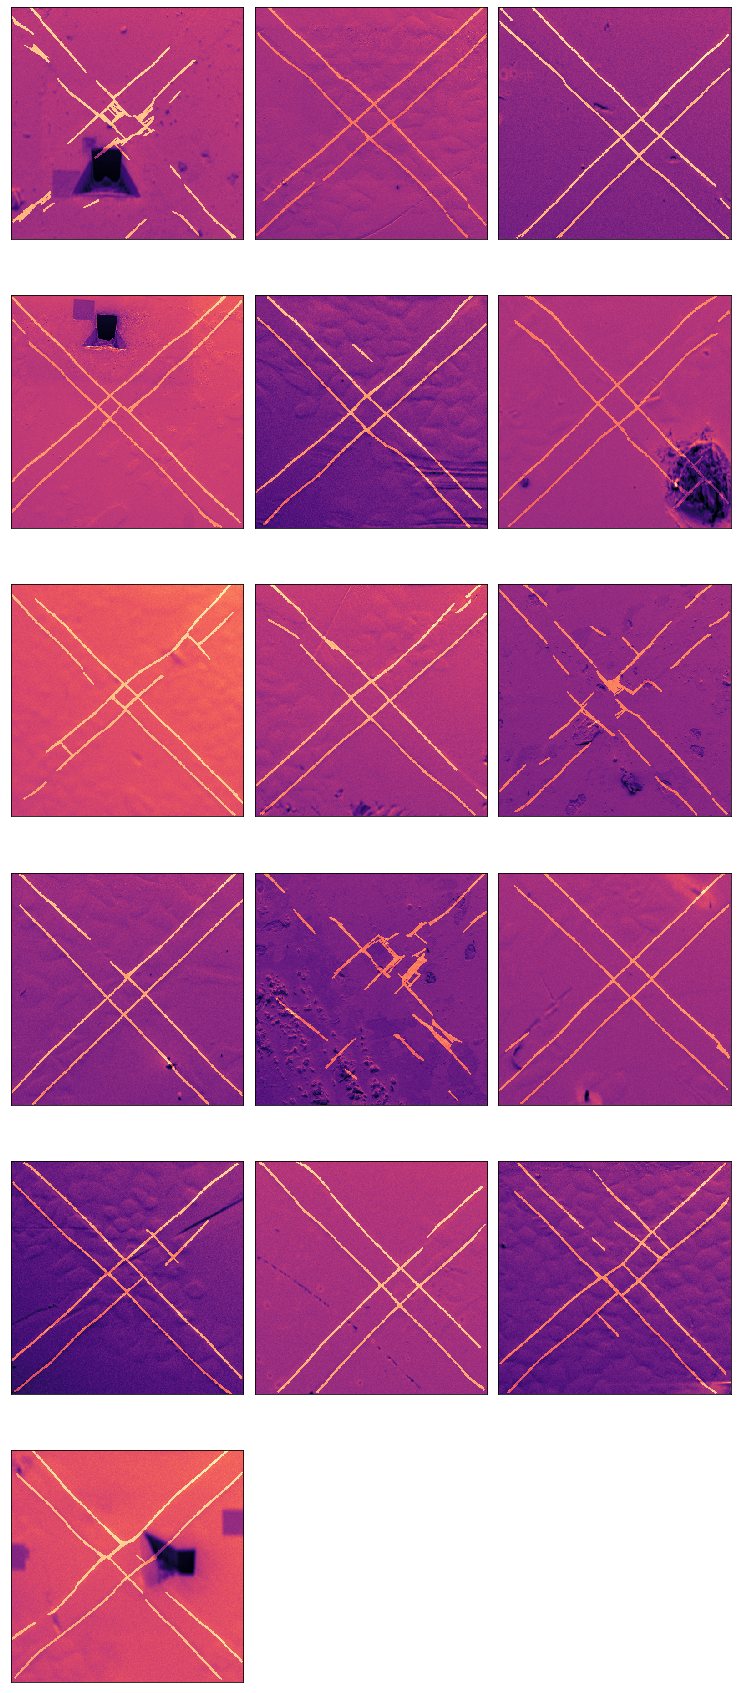

In [7]:
%matplotlib inline
theta_plus = [ np.pi*sqrt(2)*0.5+i for i in np.linspace(-0.17, 0.17, num=5) ]
theta_minus = [ -np.pi*sqrt(2)*0.5+i for i in np.linspace(-0.17,0.17,num=5)]
ftheta = theta_plus+theta_minus

fig = plt.figure(figsize=(10,80))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(16):
    ax = fig.add_subplot(20, 3, i + 1, xticks=[], yticks=[])
    img = np.zeros((512,512,3),dtype = np.uint8)
    img1 = cv2.resize(test_tensors[i].reshape(256,256),(512,512))*255.
    img[:,:,:] = cv2.cvtColor(img1,cv2.COLOR_GRAY2RGB)
    img_p0 =y_test[i,:,:]
    img_p = img_p0.reshape((256,256))
    img_p = cv2.resize(img_p,(512,512))
    imgw, fa = autoThreshold(img_p,0.1)
    skel = skeletonize(imgw>0)
    skel = borderEnhancer(skel,[2,2])
    lines = probabilistic_hough_line(skel,threshold=10, line_length=20,
                                 line_gap=20, theta = np.array(ftheta))
    im2 = np.zeros((512,512))
    for line in lines:
        p0, p1 = line
        cv2.line(im2, p0, p1,255, thickness=2, lineType=8, shift=0)
    
    img_p1 = cv2.imread(sample_test[i],0)
    img = cv2.addWeighted(np.uint8(img_p1),0.8,np.uint8(im2),0.2,0)
    ax.imshow(np.squeeze(img), cmap='magma')

plt.show()

But this is not enough. Many of this images show "lines", but they are just segments attached. Lens distorsions and other artifacts can be a difficulty to find a straight line, which will be taken as reference to calculate the middle point. 

For this reason, we developed the getPeaks function (package cross_detector_utils). The getPeaks is the core of the line detector because it uses information of the expected two orthogonal pair of lines crossing. It operates like this:
   - 1) Calculates the orientation of each pixel of the image. The orientation is based on gradient orientations, then grouped using [SLIC clustering](https://www.epfl.ch/labs/ivrl/research/slic-superpixels/). Ridge orientations are calculated using the functions described by [Peter Kovesi](https://www.peterkovesi.com/matlabfns/).
   - 2) The orientation image is convolved and projected into a 1D space by summing up all the convolutions into one degree direction. To detect a line, a peak is then detected. Projections are repeated for 45 degrees and -45 degrees with an 10 degrees up and down. The peaks are detected using Non Maxima Supression
   - 3) We force the NMS to detect a total of 6 lines per degree (a total of 12 lines). Then, we remove the wrong peaks by providing an argument gridsize, which implies, that lines must be separated at least that number of pixels between them. Also, this function takes in account that we are expecting a 2 lines crossing with 2 lines pattern. 
   - 4) It returns all the peaks on the 1D space that belong to a line
   
   The getPeaks function can fail because the parameter gridsize (line separation) might change depending on the magnification at what the image was acquired. If that is the case and we have several magnifications, we can try several calls (in our case we provided two magnification, 35 and 18 pixels wide).
   
The second function is the one that transforms back the peaks to real lines in the image. It computes also the intersections between the lines and returns the central point of the intersection.
    

In [8]:
def plot_center(img, img2, verbose = False):
    img   = img.reshape((256,256))
    
    # Same procedure as before.
    imgw, fa = autoThreshold(img,0.1)
    skel = skeletonize(imgw>0)
    skel = borderEnhancer(skel,[2,2])
    lines = probabilistic_hough_line(skel,threshold=10, line_length=20,
                                 line_gap=20, theta = np.array(ftheta))
    # Draw lines
    im2 = np.zeros((256,256))
    for line in lines:
        p0, p1 = line
        cv2.line(im2, p0, p1,255, thickness=2, lineType=8, shift=0)
    imgw[im2<255]=0
    
    fpeaks_pos, fpeaks_neg, _ = getPeaks(img2,imgw,[35], verbose)
    if fpeaks_pos.shape[0] == 0 or  fpeaks_neg.shape[0] == 0 :
        fpeaks_pos, fpeaks_neg,_ = getPeaks(img2, imgw, [18], verbose)
        if fpeaks_pos.shape[0] == 0 or fpeaks_neg.shape[0] == 0:
            print("No peaks found")
            iimgc = img2
            cpoint = []
            fpoints = []
        else:    
            cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img2*255),fpeaks_pos, fpeaks_neg)
    else:    
        cpoint, fpoints, iimgc, _ =selectGridPoints(np.uint8(img2*255),fpeaks_pos, fpeaks_neg)
    return iimgc, cpoint, fpoints

0
Angle sum :91.0
1
Angle sum :90.0
2
Angle sum :91.0
3
Angle sum :90.0


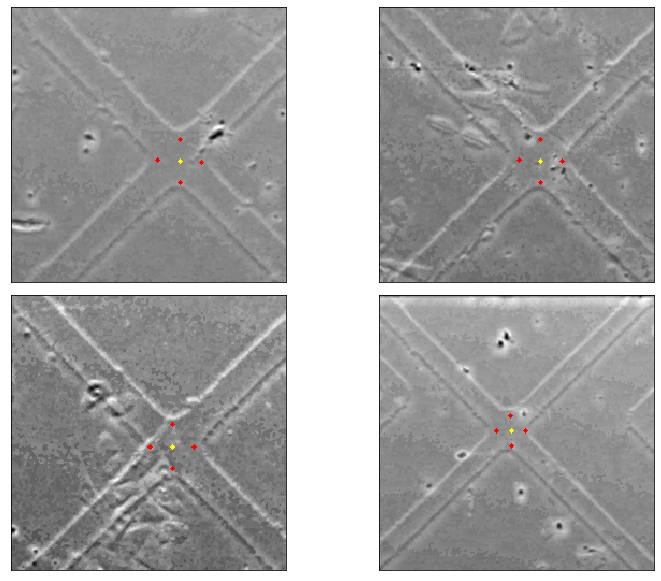

In [14]:
fig = plt.figure(figsize=(10,80))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(0,4):
    print(i)
    ax = fig.add_subplot(20, 2, i + 1, xticks=[], yticks=[])
    img = y_test[i,:,:]
    img_p0 = np.squeeze(test_tensors[i,:,:])
    iimgc, _, _  = plot_center(img, img_p0, verbose = True)
    ax.imshow(np.squeeze(iimgc))

plt.show()

Let's compute now one of the Test datasets as example (19 Oct):

In [13]:
# Read all the images 
dirSample = ".\\data\\crosses\\TEST"
flist = glob.glob(dirSample + "\\SCAN_19Oct\\ref*.tif")
test_tensors = paths_to_tensor(flist)
test_tensors = np.expand_dims(test_tensors, axis=3)
y_test = loaded_model.predict(test_tensors) 

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.91it/s]


In [16]:
import csv
import cv2
for i in tqdm(range(len(y_test))):    
    img = y_test[i,:,:]
    img_p0 = np.squeeze(test_tensors[i,:,:])
    iimgc, cpoint, _  = plot_center(img, img_p0, verbose = True)
    # Create folder
    h,t = os.path.split(flist[i])
    name = "cross_"+t[:-4]
    letter = t[6:8]
    name_file = h+"\\"+name+"\\"+t[:-4]+"_pixels.csv"
    name_image = name+"\\cent_"+t[6:]
    if not os.path.exists(h+"\\"+name):
        os.mkdir( h+"\\"+name)
    with open(name_file, mode='w') as coord_file:
        d_writer = csv.writer(coord_file, delimiter=',')
        d_writer.writerow([2*cpoint[0],2*cpoint[1],1.0,letter])
        cv2.imwrite(h+"\\"+name_image,iimgc)

  2%|█▋                                                                                 | 1/50 [00:06<05:03,  6.20s/it]

Angle sum :91.0


  4%|███▎                                                                               | 2/50 [00:12<04:58,  6.21s/it]

Angle sum :90.0


  6%|████▉                                                                              | 3/50 [00:18<04:48,  6.14s/it]

Angle sum :91.0


  8%|██████▋                                                                            | 4/50 [00:30<06:02,  7.88s/it]

Angle sum :90.0


 10%|████████▎                                                                          | 5/50 [00:36<05:28,  7.30s/it]

Angle sum :92.0


 12%|█████████▉                                                                         | 6/50 [00:42<05:03,  6.90s/it]

Angle sum :92.0


 14%|███████████▌                                                                       | 7/50 [00:48<04:45,  6.65s/it]

Angle sum :90.0


 16%|█████████████▎                                                                     | 8/50 [00:54<04:30,  6.44s/it]

Angle sum :90.0


 18%|██████████████▉                                                                    | 9/50 [01:00<04:17,  6.28s/it]

Angle sum :91.0


 20%|████████████████▍                                                                 | 10/50 [01:06<04:07,  6.18s/it]

Angle sum :90.0


 22%|██████████████████                                                                | 11/50 [01:12<03:58,  6.12s/it]

Angle sum :91.0


 24%|███████████████████▋                                                              | 12/50 [01:18<03:50,  6.07s/it]

Angle sum :91.0


 26%|█████████████████████▎                                                            | 13/50 [01:24<03:44,  6.06s/it]

Angle sum :92.0


 28%|██████████████████████▉                                                           | 14/50 [01:30<03:36,  6.01s/it]

Angle sum :91.0


 30%|████████████████████████▌                                                         | 15/50 [01:35<03:29,  5.98s/it]

Angle sum :92.0


 32%|██████████████████████████▏                                                       | 16/50 [01:41<03:22,  5.96s/it]

Angle sum :88.0


 34%|███████████████████████████▉                                                      | 17/50 [01:47<03:16,  5.96s/it]

Angle sum :90.0


 36%|█████████████████████████████▌                                                    | 18/50 [01:53<03:10,  5.95s/it]

Angle sum :91.0


 38%|███████████████████████████████▏                                                  | 19/50 [01:59<03:04,  5.94s/it]

Angle sum :91.0


 40%|████████████████████████████████▊                                                 | 20/50 [02:05<02:58,  5.94s/it]

Angle sum :91.0


 42%|██████████████████████████████████▍                                               | 21/50 [02:11<02:52,  5.94s/it]

Angle sum :90.0


 44%|████████████████████████████████████                                              | 22/50 [02:17<02:46,  5.94s/it]

Angle sum :91.0


 46%|█████████████████████████████████████▋                                            | 23/50 [02:23<02:40,  5.95s/it]

Angle sum :90.0


 48%|███████████████████████████████████████▎                                          | 24/50 [02:29<02:34,  5.94s/it]

Angle sum :90.0


 50%|█████████████████████████████████████████                                         | 25/50 [02:35<02:28,  5.93s/it]

Angle sum :92.0


 52%|██████████████████████████████████████████▋                                       | 26/50 [02:41<02:22,  5.93s/it]

Angle sum :90.0


 54%|████████████████████████████████████████████▎                                     | 27/50 [02:47<02:17,  5.96s/it]

Angle sum :92.0


 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:53<02:10,  5.95s/it]

Angle sum :90.0


 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:59<02:04,  5.95s/it]

Angle sum :90.0


 60%|█████████████████████████████████████████████████▏                                | 30/50 [03:05<01:58,  5.95s/it]

Angle sum :97.0


 62%|██████████████████████████████████████████████████▊                               | 31/50 [03:10<01:53,  5.95s/it]

Angle sum :90.0


 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:17<01:47,  5.97s/it]

Angle sum :89.0


 66%|██████████████████████████████████████████████████████                            | 33/50 [03:22<01:41,  5.96s/it]

Angle sum :89.0


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [03:28<01:35,  5.96s/it]

Angle sum :91.0


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:34<01:29,  5.96s/it]

Angle sum :92.0


 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:40<01:23,  5.97s/it]

Angle sum :90.0


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:46<01:17,  5.97s/it]

Angle sum :90.0


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:52<01:11,  5.96s/it]

Angle sum :91.0


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:58<01:05,  5.95s/it]

Angle sum :92.0


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [04:04<00:59,  5.94s/it]

Angle sum :90.0


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [04:10<00:53,  5.94s/it]

Angle sum :92.0


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [04:16<00:47,  5.95s/it]

Angle sum :89.0


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [04:22<00:41,  5.95s/it]

Angle sum :92.0


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [04:28<00:35,  5.95s/it]

Angle sum :89.0


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [04:34<00:29,  5.96s/it]

Angle sum :91.0


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:40<00:23,  5.95s/it]

Angle sum :93.0


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:46<00:17,  5.96s/it]

Angle sum :91.0


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:58<00:15,  7.74s/it]

Angle sum :92.0


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [05:10<00:09,  9.00s/it]

Angle sum :90.0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:22<00:00,  6.44s/it]

Angle sum :91.0


## Part 2 : Computing accuracy on detection.
 
 We obtained images from scans not used to train the neural network, we passed the network and did postprocessing and now we want to analyse how well our method performs.
 
 The error will be evaluated as it follows:
   - First we compare against an analog solution, an algorithm in Matlab (similar to the current one but without using neural networks). This algorithm was developed and used to generate the images that trained the neural network with (after curation) and can be found in the folder matlab_crossdetector. 
   - Second, as a ground truth we use a person clicking on the center of cross. ImageJ is used with the Measurement tool to set the center of the images manually and the results stored in a .csv file.
   - The Mean Square Error (difference in distance squared) is computed respect the manual (ground truth) for both methods. The images with high error rate will be subjected to error analysis. 


### The Matlab solution (without machine learning)

<img src="panelMatlab1_0.png"> 

The Matlab algorithm (Matlab GLD, Grid Line Detector), was originally developed for the crossing detection, when the amount of data for training available was very small. 
- First it detects edges using canny thresholding (top left picture). 
- Then it finds the gradient orientations (top left second picture) and detects the maximum density of orientations, i.e., same value of angles for each pixel are clustered (top left third picture). 
- With this information, purges the thresholding (top right first image) 
- Then applies a stroke width transform (bottom left first picture). 
- The final image analyzed is the pixels that belong to a border of the grid. 
- The orientation line detector procedure is the same as the one we used before after applying the neural network (last three bottom pictures).

Since the usual pixel size is 0.6 micrometers, we consider that an error of 3 micrometers (5 pixels) to the center is good enough to be considered ground truth (even for humans is hard to make a difference). The corresponding datasets are set 1, 13 July, with n=63 images, set 2 14 Nov with n = 36 images, set 3 19 Oct with n = 50 images. The errors are in pixels, then the total of samples is split in center hit (good), small error (the error is still acceptable for our transformation) or completely off.

<table border = "1">
         <tr>
            <th>Algorithm, n <br> MSE +/-STD pixels</th>
            <th>Center hit (0-5)</th>
            <th>Small error(5-10)</th>
            <th>High error (error bigger than 10)</th>
            <th>Failure</th>
         </tr>
         <tr>
            <td>Matlab GLD set 1<br><br> 15.1143 +/- 15.9949</td>
            <td>n = 12 <br><br> 3.6755 +/- 0.9113 pix</td>
            <td>n= 23 <br><br> 5.9786 +/- 2.2081 pix </td>
            <td>n=21 <br><br> 30.3403 +/- 17.4867 pix</td>
            <td>n=7</td>
         </tr>    
         <tr>
            <td>Matlab GLD set 2<br><br> 17.7401 +/- 26.9252</td>
            <td>n=17 <br><br>2.9055 +/- 1.3521</td>
            <td>n=6 <br><br>4.051 +/- 2.4082</td>
            <td>n=9 <br><br>52.7233 +/- 29.6269</td>
             <td>n=4</td>
         </tr>
             <tr>
            <td>Matlab GLD set 3<br><br> 6.4056 +/- 13.1991 </td>
            <td>n=31 <br><br> 2.8411 +/- 1.2309 </td>
            <td>n=15 <br><br> 4.0398 +/- 2.0871</td>
            <td>n=2 <br><br> 60.8186 +/- 42.5803 </td>
             <td>n=2</td>
         </tr>
         <tr>
            <td>U-net+LD set 1<br><br> 5.6231 +/- 3.8352 </td>
            <td>n=28 <br><br>  2.9516 +/- 1.1234 pix</td>
            <td>n=31 <br><br> 4.8749 +/- 2.2241 </td>
            <td>n=4 <br><br>16.6598 +/- 5.9106</td>
             <td>-</td>
         </tr>
          <tr>
            <td>U-net+LD set 2<br><br> 8.0371 +/- 9.7903</td>
            <td>n=17 <br><br> 3.0579 +/- 0.959</td>
            <td>n=13 <br><br> 4.9012 +/- 2.4785</td>
            <td>n=6 <br><br> 23.7161 +/- 16.7727</td>
             <td>-</td>
         </tr>
         <tr>
            <td>U-net+LD set 3<br><br> 5.6761 +/- 4.4071 </td>
            <td>n = 26 <br><br> 3.218 +/- 1.2731</td>
            <td>n = 21 <br><br> 4.8143 +/- 2.1579</td>
            <td>n = 3 <br><br> 19.1784 +/- 8.8222</td>
            <td>-</td>
         </tr>
</table>



The values from the table come from the following:

In [18]:
## Calculations using pandas 
### Read the files with manual annotations
import pandas as pd

dirSample = ".\\data\\crosses"
flist = glob.glob(dirSample + "\\TEST_curated\\Results*.csv")
dfManual = pd.DataFrame()
for f in flist:
    h, t = os.path.split(f)
    d = pd.read_csv(f, index_col=0)
    d['Label'] = [el[6:8] for el in d['Label']]
    d['Dataset'] = t[:-4]
    dfManual = pd.concat([dfManual,d])
dfManual

,Label,X,Y,Dataset
,,,,
1,7M,279.000,282.000,Results_13Jul
2,2F,250.000,238.000,Results_13Jul
3,2G,251.000,240.000,Results_13Jul
4,2H,254.000,237.000,Results_13Jul
5,2I,248.000,243.000,Results_13Jul
...,...,...,...,...
46,aO,254.000,246.000,Results_19Oct
47,aN,253.333,250.000,Results_19Oct
48,2P,252.000,271.333,Results_19Oct


In [19]:
# Read values from Matlab algorithm
# Load data
dirSample = ".\\data\\crosses"
flist = glob.glob(dirSample + "\\TEST_curated\\SCAN*")
flistdir= [f for f in flist if os.path.isdir(f)]

dfMatlab = pd.DataFrame()
for sample_file in tqdm(flistdir):  
    flist2 = glob.glob(sample_file + "\\*cross_*")
    for el in flist2:
        t,h  = os.path.split(el)
        _,t = os.path.split(t)
        file_pix = glob.glob(el+"\\*pixels.csv")
        if file_pix:
            d = pd.read_csv(file_pix[0], header= None)        
            d = d.rename(columns={0:'X',1:'Y'})
            d = d.drop([2], axis=1)
        else:
            d = pd.DataFrame()
            d.at[0,'X'] = np.inf
            d.at[0,'Y'] = np.inf
        d['Dataset'] = t 
        d['Label'] = h[16:18]
        dfMatlab = pd.concat([dfMatlab,d])
dfMatlab = dfMatlab.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.41it/s]


In [20]:
dfMatlab

,X,Y,Dataset,Label
0,245.00,240.00,SCANS_13Jul,2F
1,248.50,249.00,SCANS_13Jul,2G
2,269.00,229.00,SCANS_13Jul,2H
3,253.50,248.00,SCANS_13Jul,2I
4,231.25,263.50,SCANS_13Jul,2J
...,...,...,...,...
144,252.50,249.00,SCAN_19Oct,aN
145,248.50,245.75,SCAN_19Oct,aO
146,inf,inf,SCAN_19Oct,2P
147,263.50,247.00,SCAN_19Oct,1O


In [21]:
# And now for our current implementation
dirSample = ".\\data\\crosses"
flist = glob.glob(dirSample + "\\TEST\\SCAN*")
flistdir= [f for f in flist if os.path.isdir(f)]
dfC = pd.DataFrame()
for sample_file in tqdm(flistdir):
    flist2 = glob.glob(sample_file + "\\*cross*_ref_*\\*pix*.csv*")
    for el in flist2:
        d = pd.read_csv(el, header= None)
        t,h  = os.path.split(el)
        t2,t0 = os.path.split(t)
        _,t = os.path.split(t2)
        d['Dataset'] = t 
        d['ImageTag'] = t0[20:]
        d = d.rename(columns={0:'X',1:'Y',3:'Label'})
        dfC = pd.concat([dfC,d])
dfC = dfC.drop([2,4], axis=1)
dfC = dfC.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.83it/s]


In [22]:
dfC

,X,Y,Label,Dataset,ImageTag
0,251,243,2F,SCAN_13Jul,2F_201901111819488113
1,252,244,2G,SCAN_13Jul,2G_201901111812337352
2,257,242,2H,SCAN_13Jul,2H_201901111803079367
3,234,257,2I,SCAN_13Jul,2I_201901111759023676
4,259,242,2J,SCAN_13Jul,2J_201901111748250215
...,...,...,...,...,...
144,256,250,aN,SCAN_19Oct,1071805079016
145,252,248,aO,SCAN_19Oct,1071803197717
146,252,272,2P,SCAN_19Oct,1071730534941
147,260,242,1O,SCAN_19Oct,1071731385247


In [23]:
def getDifferences(dRef,dA):
    # Join dataframes by Label
    dc = dRef.join(dA.set_index('Label'), on='Label',lsuffix='_ref')
    # Calculate the difference between the dRef and dA
    dc['diff_X'] = (dc.X-dc.X_ref)
    dc['diff_Y'] = (dc.Y-dc.Y_ref)
    dc['distance'] = np.sqrt(dc.diff_X*dc.diff_X + dc.diff_Y*dc.diff_Y)
    return dc
def reportValues(d):
    print('N:',len(d))
    print('Failure:',len(d[d.distance==np.inf]))
    d = d[d.distance!=np.inf]
    print('Total MSE:',np.round(d['distance'].mean(),4),"+/-",np.round(d['distance'].std(),4))
    dm10 = d[d.distance > 10]
    print('More than 10 pix distance:',len(dm10))
    print('MSE >10 pix:',np.round(dm10['distance'].mean(),4),"+/-",np.round(dm10['distance'].std(),4))
    
    d10 = d[d.distance <= 10]
    print('5-10 pix  :',len(d10[d10.distance>5]))
    print('MSE 5-10 pix:',np.round(d10['distance'].mean(),4),"+/-",np.round(d10['distance'].std(),4))
    
    d5 = d[d.distance<=5]
    print('Less than 5 pix:',len(d5))
    print('MSE <5 pix:',np.round(d5['distance'].mean(),4),"+/-",np.round(d5['distance'].std(),4))

In [24]:
d1 = dfManual[dfManual['Dataset']=='Results_13Jul']
d1Matlab = dfMatlab[dfMatlab['Dataset']=='SCANS_13Jul']
d1C = dfC[dfC['Dataset']=='SCAN_13Jul']

In [25]:
dcMat = getDifferences(d1,d1Matlab)
reportValues(dcMat)

N: 63
Failure: 7
Total MSE: 15.1143 +/- 15.9949
More than 10 pix distance: 21
MSE >10 pix: 30.3403 +/- 17.4867
5-10 pix  : 23
MSE 5-10 pix: 5.9786 +/- 2.2081
Less than 5 pix: 12
MSE <5 pix: 3.6755 +/- 0.9113


In [26]:
dcC = getDifferences(d1,d1C)
reportValues(dcC)

N: 63
Failure: 0
Total MSE: 5.6231 +/- 3.8352
More than 10 pix distance: 4
MSE >10 pix: 16.6598 +/- 5.9106
5-10 pix  : 31
MSE 5-10 pix: 4.8749 +/- 2.2241
Less than 5 pix: 28
MSE <5 pix: 2.9516 +/- 1.1234


In [27]:
d2 = dfManual[dfManual['Dataset']=='Results_14Nov']
d2Matlab = dfMatlab[dfMatlab['Dataset']=='SCAN_14Nov']
d2C = dfC[dfC['Dataset']=='SCAN_14Nov']

dc2Mat = getDifferences(d2,d2Matlab)
reportValues(dc2Mat)

N: 36
Failure: 4
Total MSE: 17.7401 +/- 26.9252
More than 10 pix distance: 9
MSE >10 pix: 52.7233 +/- 29.6269
5-10 pix  : 6
MSE 5-10 pix: 4.051 +/- 2.4082
Less than 5 pix: 17
MSE <5 pix: 2.9055 +/- 1.3521


In [28]:
d2C = getDifferences(d2,d2C)
reportValues(d2C)

N: 36
Failure: 0
Total MSE: 8.0371 +/- 9.7903
More than 10 pix distance: 6
MSE >10 pix: 23.7161 +/- 16.7727
5-10 pix  : 13
MSE 5-10 pix: 4.9012 +/- 2.4785
Less than 5 pix: 17
MSE <5 pix: 3.0579 +/- 0.959


In [29]:
d3 = dfManual[dfManual['Dataset']=='Results_19Oct']
d3Matlab = dfMatlab[dfMatlab['Dataset']=='SCAN_19Oct']
d3C = dfC[dfC['Dataset']=='SCAN_19Oct']

dc3Mat = getDifferences(d3,d3Matlab)
reportValues(dc3Mat)

N: 50
Failure: 2
Total MSE: 6.4056 +/- 13.1991
More than 10 pix distance: 2
MSE >10 pix: 60.8186 +/- 42.5803
5-10 pix  : 15
MSE 5-10 pix: 4.0398 +/- 2.0871
Less than 5 pix: 31
MSE <5 pix: 2.8411 +/- 1.2309


In [30]:
dc3C = getDifferences(d3,d3C)
reportValues(dc3C)

N: 50
Failure: 0
Total MSE: 5.8163 +/- 6.3874
More than 10 pix distance: 5
MSE >10 pix: 18.4684 +/- 14.5132
5-10 pix  : 16
MSE 5-10 pix: 4.4105 +/- 2.4648
Less than 5 pix: 29
MSE <5 pix: 2.9006 +/- 1.2473


In [31]:
dcC[dcC['distance']>10]

,Label,X_ref,Y_ref,Dataset_ref,X,Y,Dataset,ImageTag,diff_X,diff_Y,distance
,,,,,,,,,,,
5,2I,248.0,243.0,Results_13Jul,234,257,SCAN_13Jul,2I_201901111759023676,-14.0,14.0,19.798990
34,7G,248.0,248.0,Results_13Jul,244,259,SCAN_13Jul,7G_201901111751496771,-4.0,11.0,11.704700
41,7Q,263.0,252.0,Results_13Jul,278,270,SCAN_13Jul,7Q_201901111723558197,15.0,18.0,23.430749
55,9N,241.0,237.0,Results_13Jul,245,226,SCAN_13Jul,9N_201901111707572251,4.0,-11.0,11.704700


In [32]:
# Total
dt = pd.concat([dcC,d2C,dc3C])
dt[dt['distance']<10].mean()

X_ref       262.723180
Y_ref       254.588060
X           262.984962
Y           256.774436
diff_X        0.261782
diff_Y        2.186376
distance      4.685168
dtype: float64

In [33]:
dt[dt['distance']<10].std()

X_ref       23.807217
Y_ref       17.489483
X           23.610150
Y           17.086064
diff_X       3.481922
diff_Y       3.239496
distance     2.320889
dtype: float64

In [34]:
dtMat = pd.concat([dcMat,dc2Mat,dc3Mat])
dtMat[dtMat['distance']<np.inf].mean()

X_ref       261.231574
Y_ref       254.301809
X           259.419118
Y           255.218750
diff_X       -1.812456
diff_Y        0.916941
distance     12.658462
dtype: float64

In [35]:
dtMat[dtMat['distance']<np.inf].std()

X_ref       23.820857
Y_ref       17.518356
X           30.540348
Y           22.229452
diff_X      16.388854
diff_Y      15.574133
distance    18.811722
dtype: float64

### Summary and conclusions

In SEM images, gradients are diffuse and very often blurry or missing. We developed GLD to detect the lines associated to the grid edges, but it was found to have a big error rate: 

**N: 149**
- Total MSE GLD (Matlab) =  12.66 +/- 18.811722
- Total MSE Unet-LD: 6.23 +/-(STD) 6.03

Thus, we decided to generate a corpus of data for training. We used GLD first and then curated the errors manually. A total of 600 images collected from different experiments were used. CLAHE (32x32 filter size) and gaussian blur (sigma 1, 5x5 filter size) was applied to images as preprocessing. After this they were augmented until 5000 images were reached, by variations in scaling, rotation, translation and intensity values. Finally, they were normalized after augmentation.   

Convolutional neural networks have proved to be  very resilient to noise in detection, so a convolutional auto-encoder (U-Net, _Ronneberger, Fischer and Brox, 2015_) was trained for detection of edges. Implementation was carried out using the framework Keras with Tensorflow. The output provided a probability map for each pixel, which determines if grid borders could positively be found. The function loss to train used was binary cross-entropy (sum of values that match ground truth). Adam was used as optimizer with a learning rate of 1e-4.  

With the probability map computed, the last part of the GLD algorithm was adapted to provide the final centered result. GLD finds the peaks based on the maximum probability of an existing segment in a certain angle and provide results in the form of lines. Lines are intersected and the center point found.

 The following panel provides 3 images with errors bigger than 10 pixels for the 1st, 2nd and 3rd dataset:
 
 <img src="panelErrors3.png" title="Dataset 13 Jul">
 <img src="panelErrors2.png" title="Dataset 14 Nov">
 <img src="panelErrors.png" title="Dataset 19 Oct">
 

As we can observe, real life samples can present all kind of challenges for the detection, and we can expect that around 10% of the points have high probability of providing an error. The irregular surface topology of the resin block imaged by the SEM, together with the variety of conditions for each sample (different focus, different brightness and contrast, different size of the shadowing at the edges of the grid or differences in manufacturing of the grid); makes it difficult to achieve a human level of error. 
 
It is likely that with more data and some recent improvements (like self-attention or a deeper specialized netwokr) we could improve our results. In average, we can expect a mean square error of 4.15+/-4 micrometers respect ground truth. By removing the 10% outliers (the ones that really far off, and then easier to detect),  the mean square error respect ground truth drops to 3.48 +/-1.45 micrometers, which is an acceptable error for the computation of an affine transformation.